# Big data lab

Етапи роботи:
1. **Побудува базової моделі використовуючи LightGBM**
- missing values замінив -1
- розбивка на валідаційну і тестову вибірки
- підбір гіперпараметрів через hyperopt
2. **Побудова Ансамблю моделей**
- Random Forest
- LogisticRegression
- LGBM 
- тюнінг гіперпараметрів моделей
- результат виявився гірший за base model. Повернувся до 1-го пункту.
3. **Робота із датасетом DPI**
- написана функція для транспонування датасету
- додав датасет в df_train_fe
- тренування на LGBM
- підбір гіперпараметрів
- результати виявились гіршими від base model. Повертаюсь до пункту 1.
4. **Feature importance**
- виділив з базової моделі найбільш важливі features.
- будую матрицю кореляцій по Спірмену, щоб виявити висококорельовані ознаки.
- перенавчаю модель на новому наборі фічей
- результат ROC-AUC = 0.87. Результат не влаштовує.
5. **Стратифікація вибірки**
- заново тренування моделі на базових фічах
- роблю знов пункт 4 (feature importance із порогом кореляції 0,95)
- відбираю 312 фічей
- треную модель
- вийшов на результат ROC-AUC 0.896 (LGBMClassifier_01072023_15_56.pickle)


## import library

In [39]:
import pandas as pd
import pickle
import my_func
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import KFold 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime, timedelta
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
import shap
from hyperopt import hp, fmin, tpe

sns.set()

fe_name_tr = 'churn_train_model_fe.pickle'
b_num_name_tr ='churn_train_model_b_num.pickle'
dpi_name_tr ='churn_train_model_dpi.pickle'

fe_name_te = 'churn_test_model_fe.pickle'
b_num_name_te ='churn_test_model_b_num.pickle'
dpi_name_te ='churn_test_model_dpi.pickle'

file_path = r'D:\BDL-Final\data-from-BDL' + '\\'

# settings for dataframe
pd.set_option('display.max_columns', None)

In [2]:
# Load dataframes
df_train_fe = pd.read_pickle(file_path+fe_name_tr)
df_train_dpi = pd.read_pickle(file_path+dpi_name_tr)
df_train_b_num = pd.read_pickle(file_path+b_num_name_tr)

df_test_fe = pd.read_pickle(file_path+fe_name_te)
df_test_dpi = pd.read_pickle(file_path+dpi_name_te)
df_test_b_num = pd.read_pickle(file_path+b_num_name_te)



# LGBM base model

## LGBM

In [5]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import numpy as np


# Prepare your data (X and y)
X = df_train_fe.drop(['target', 'abon_id'], axis=1)
y = df_train_fe['target']

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=777)

# Define the LGBMClassifier model
clf = lgb.LGBMClassifier(is_unbalance=True)

# Define the number of folds for cross-validation
n_splits = 5

# Initialize an empty list to store the test AUC scores for each fold
test_scores = []

# Perform K-fold cross-validation
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)
for train_index, test_index in kf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Train the model on the current fold
    clf.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation set of the current fold
    y_val_pred = clf.predict(X_test_fold)
    
    # Calculate and store the AUC score for the current fold
    test_scores.append(roc_auc_score(y_test_fold, y_val_pred))

# Print the test AUC scores for each fold
for i, score in enumerate(test_scores):
    print(f"Fold {i+1} Test AUC = {score:.3f}")

# Calculate and print the average test AUC across all folds
print(f"Average Test AUC = {np.mean(test_scores):.3f}")


Fold 1 Test AUC = 0.826
Fold 2 Test AUC = 0.821
Fold 3 Test AUC = 0.818
Fold 4 Test AUC = 0.826
Fold 5 Test AUC = 0.815
Average Test AUC = 0.821


In [6]:
#saving model
my_func.save_model(clf, X.columns.tolist()) 


Save LGBMClassifier_01072023_14_50.pickle


## Prediction using Test dataset (df_test_fe)

Test AUC = 0.897
Metrics         Train      Test       Δ         
roc_auc         0.8188    
accuracy        0.8642    
precision       0.284     
recall          0.7669    
f1_score        0.4145    


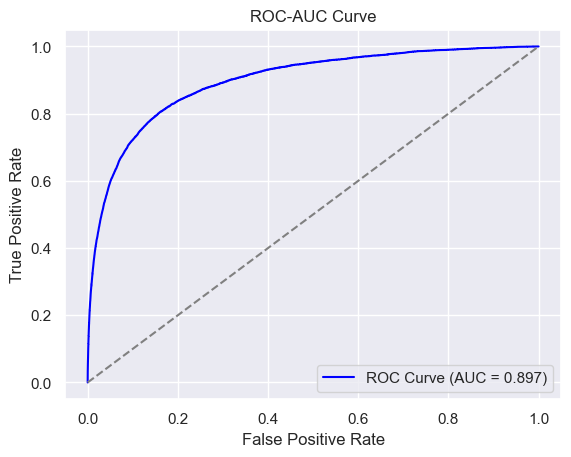

In [7]:

import lightgbm as lgb
import pickle
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Define the file name of the pickle file
#pickle_file = "LGBMClassifier_24062023_15_30.pickle"
pickle_file = "LGBMClassifier_01072023_14_50.pickle"


# Load the model
model_test, features = my_func.load_pickle(pickle_file)

# Prepare the test data (X_test)


y_test = df_test_fe['target']
X_test = df_test_fe.drop(['target', 'abon_id'], axis=1)
#X_test.fillna(-1, inplace=True)

# Make predictions on the test data
y_pred = model_test.predict(X_test)

# Calculate the probabilities of the positive class
y_pred_proba = model_test.predict_proba(X_test)[:, 1]

# Calculate the ROC-AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC = {auc:.3f}")


# Calculate and print out the binary classification metrics
my_func.binary_classification_metrics(y_true_tr=y_test, y_pred_tr=y_pred, report=False)


# Plot the ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='blue', label="ROC Curve (AUC = {:.3f})".format(auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.show()


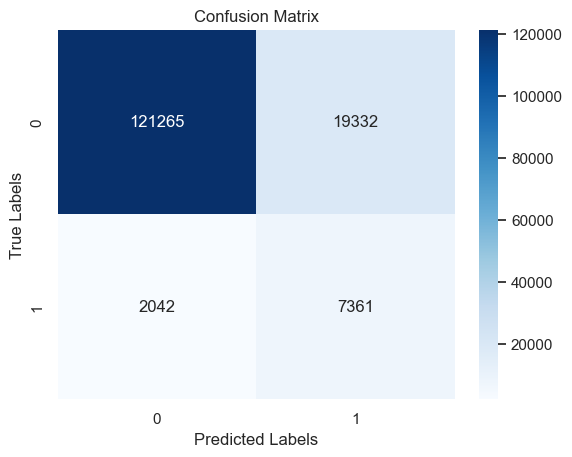

In [86]:
import seaborn as sns

# Predict test values using the LGBM model
y_pred = model_test.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Set the axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()



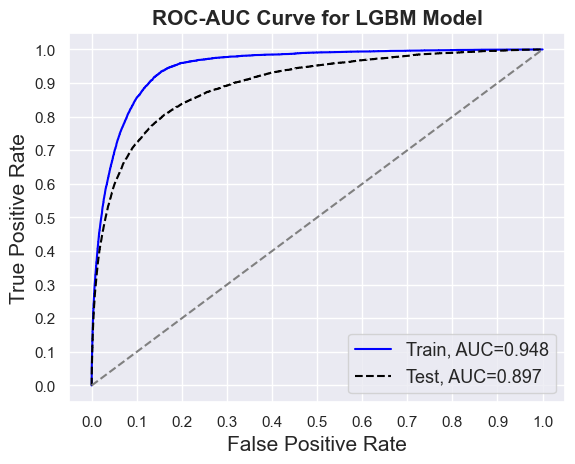

In [11]:
# Predict the probabilities for the training set
y_train_pred = clf.predict_proba(X_train)[:, 1]

# Predict the probabilities for the test set
y_test_pred = model_test.predict_proba(X_test)[:, 1]

# Plot the ROC-AUC curve
plot_roc_auc_train_test(y_train, y_train_pred, y_test, y_test_pred, "ROC-AUC Curve for LGBM Model")


In [9]:

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_auc_train_test(y_train, y_train_pred, y_test, y_test_pred, title):
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_pred)

    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)

    plt.plot(fpr_train, tpr_train, color='blue', label="Train, AUC={:.3f}".format(auc_train), linestyle='-')
    plt.plot(fpr_test, tpr_test, color='black', label="Test, AUC={:.3f}".format(auc_test), linestyle='--')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title(title, fontweight='bold', fontsize=15)
    plt.legend(prop={'size': 13}, loc='lower right')

    plt.show()

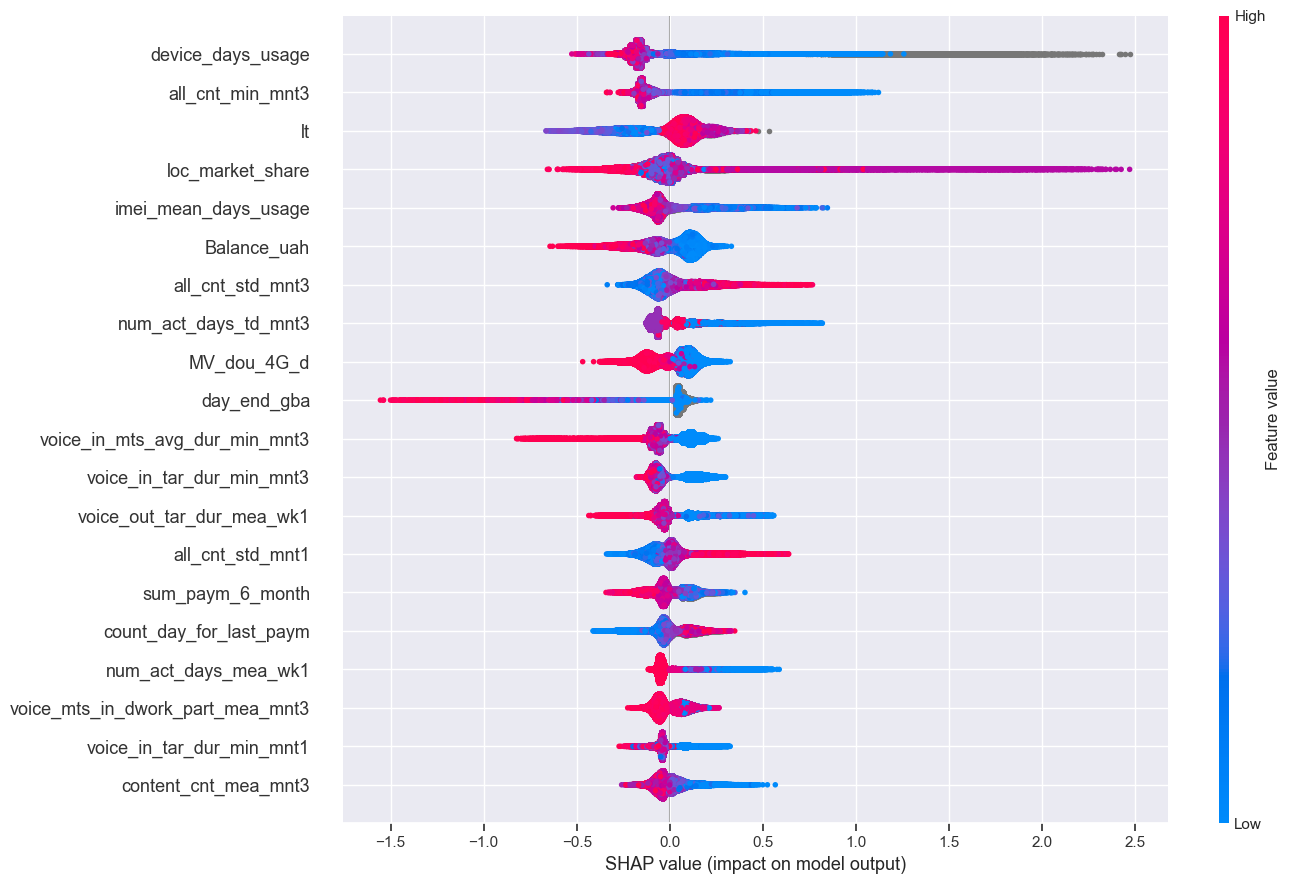

In [76]:
import shap
fea_lgb = model_test.feature_name_
explainer = shap.TreeExplainer(model_test)
shap_values = explainer.shap_values(X_test[fea_lgb])
pd.DataFrame(shap_values[1])
 
shap.summary_plot(shap_values[1], X_test[fea_lgb], plot_size=(14,9)) 



## Feature importance

In [12]:
# Get feature importances
X = df_train_fe.drop(['target', 'abon_id'], axis=1)

# завантажуємо модель
pickle_file = "LGBMClassifier_24062023_15_30.pickle"

# Load the model
model_train, features = my_func.load_pickle(pickle_file)
importances = model_train.feature_importances_
feature_names = X.columns

# Create a DataFrame with feature names and importances
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
df_importances = df_importances.sort_values(by='Importance', ascending=False)

# Print the DataFrame
df_importances

,Feature,Importance
632,loc_market_share,116
606,lt,61
634,device_days_usage,45
604,Balance_uah,41
705,day_end_gba,32
...,...,...
620,DNZ_COUNT_open_loan_year5,0
264,clc_no_vas_roam_min_mnt1,0
623,Fax,0
263,all_roam_clc_mea_wk1,0


In [13]:
df_imp=df_importances[df_importances['Importance']>0]
# Get the list of selected features
selected_features = df_imp['Feature'].tolist()

In [14]:
len(selected_features)

551

In [46]:
# Get the list of selected features
selected_features = df_imp['Feature'].tolist()

# Calculate the Spearman correlation for the selected features
correlation_matrix = df_train_fe[selected_features].corr(method='spearman')

# Display the correlation matrix
correlation_matrix

,loc_market_share,lt,device_days_usage,Balance_uah,day_end_gba,imei_mean_long_days_usage,imei_mean_days_usage,loc_is_obl_center,imei_mean_day_announced,content_cnt_mea_mnt3,sms_in_cnt_std_mnt3,MV_Traf_Cont_inc_s_Cnt,days_of_last_ppm,std_paym_6_month,days_of_end_last_ppm,num_act_days_mea_mnt1,num_act_days_mea_mnt3,content_cnt_mea_mnt1,conn_in_uniq_cnt_td_mnt3,myvf_day_usage,content_cnt_mea_wk1,voice_mts_in_drest_part_mea_wk1,device_height_mm,com_num_part_std_mnt1,avg_paym_6_month,imei_mean_price,all_cnt_std_mnt3,voice_mts_in_dwork_part_mea_mnt3,conn_out_uniq_cnt_td_mnt3,voice_mts_in_dwork_part_mea_mnt1,all_cnt_std_mnt1,voice_in_cmpttrs_avg_durmin_mnt3,voice_mts_out_dwork_partstd_mnt3,voice_mts_out_dwork_partmin_mnt1,voice_in_cmpttrs_avg_durmea_wk1,voice_in_mts_avg_dur_mea_wk1,voice_in_td_cnt_td_mnt3,count_day_for_last_paym,sum_paym_6_month,bs_ovrl_OMO_CNT_M3,max_paym_6_month,device_price,voice_in_mts_avg_dur_min_mnt1,loc_cnt_events,data_3g_tv_cnt_std_mnt1,voice_in_tar_dur_td_mnt3,voice_mts_in_dwork_part_min_mnt1,conn_in_uniq_cnt_std_mnt3,tsoa_call_cnt,data_3g_tv_cnt_std_mnt3,pay_max_td_mnt3,content_cnt_td_mnt3,data_3g_tar_vol_td_mnt3,device_width_mm,vas_clc_td_mnt3,bs_ovrl_OMO_CNT_M2,non_accum_internet_vol_min_mnt3,MV_Traf_omo_inc_v_Min,imei_max_price,voice_mts_out_drest_partmea_mnt3,device_brand_prestigio,voice_out_td_cnt_std_mnt1,voice_in_td_cnt_std_mnt3,min_paym_6_month,voice_mts_out_nrest_partmax_mnt3,num_act_days_std_mnt3,data_3g_dou_td_mnt3,sms_in_cnt_mea_wk1,voice_mts_out_nrest_partmea_mnt1,non_accum_internet_vol_mea_wk1,voice_mts_out_drest_partmea_mnt1,conn_out_uniq_cnt_std_mnt3,all_cnt_max_mnt3,voice_mts_in_dwork_part_std_mnt3,voice_out_td_cnt_std_mnt3,MV_Traf_mn_inc_v_Min,voice_mts_in_drest_part_std_mnt3,voice_out_cmpttrs_avg_dumea_wk1,voice_mts_in_drest_part_mea_mnt1,MV_Traf_2G_d_Mb,data_3g_tv_cnt_td_mnt3,voice_in_mts_avg_dur_td_mnt3,voice_mts_out_dwork_partmea_wk1,voice_out_cmpttrs_avg_dustd_mnt3,voice_out_td_cnt_td_mnt3,voice_mts_in_dwork_part_min_mnt3,MV_ot_total,voice_mts_in_dwork_part_max_mnt3,num_act_days_min_mnt3,voice_out_tar_dur_td_mnt3,voice_in_cmpttrs_avg_durmea_mnt3,voice_in_fix_tar_dur_td_mnt3,all_cnt_mea_mnt3,non_accum_internet_vol_td_mnt3,non_accum_internet_vol_mea_mnt1,device_has_lte,voice_in_td_cnt_mea_mnt1,com_num_part_mea_mnt3,voice_in_life_part_mea_mnt3,voice_out_short_part_mea_mnt3,voice_in_kievstar_part_mea_mnt3,content_cnt_std_mnt3,all_cnt_min_mnt3,sms_in_cnt_std_mnt1,MV_Traf_Cont_out_v_Min,voice_mts_out_dwork_partmea_mnt1,gprs_tar_vol_td_mnt3,pay_avg_td_mnt3,MV_Traf_4G_d_Mb,content_cnt_std_mnt1,voice_out_cmpttrs_avg_dutd_mnt3,Good_deed,voice_in_mts_avg_dur_std_mnt1,voice_in_cmpttrs_td_cnt_td_mnt3,num_act_days_td_mnt3,last_paym,cnt_paym_6_month,voice_in_mts_avg_dur_min_mnt3,voice_in_fix_tar_dur_max_mnt3,device_android_version,voice_in_tar_dur_min_mnt1,non_accum_internet_vol_std_mnt1,voice_out_short_part_max_mnt3,voice_mts_in_drest_part_max_mnt3,MV_ap_omo_out_v,conn_com_part_std_mnt3,MV_ot_Other,MV_Traf_pstn_inc_v_Min,voice_in_cmpttrs_avg_durmax_mnt3,conn_in_uniq_cnt_mea_mnt3,voice_in_fix_tar_dur_mea_mnt3,voice_in_td_cnt_std_mnt1,MV_Traf_innet_inc_v_Min,conn_com_part_mea_mnt3,data_3g_tv_cnt_min_mnt3,ks_num_part_mea_wk1,content_cnt_max_mnt1,data_3g_tv_cnt_max_mnt3,MV_Traf_ACCA_out_v_Min,voice_out_cmpttrs_avg_dumea_mnt3,data_3g_dou_std_mnt3,sms_in_cnt_mea_mnt3,device_sim_count,conn_out_uniq_cnt_mea_wk1,voice_mts_in_nwork_part_mea_wk1,voice_in_td_cnt_mea_mnt3,MV_Traf_innet_out_v_Min,conn_out_uniq_cnt_std_mnt1,voice_in_fix_tar_dur_mea_mnt1,pay_sum_td_mnt3,voice_in_cmpttrs_avg_durstd_mnt3,content_cnt_min_mnt1,voice_out_td_cnt_min_mnt1,DNZ_DAYS_from_last_year5,MV_DOU_PPM_VF,voice_out_cmpttrs_td_cnttd_mnt3,voice_out_tar_dur_mea_wk1,voice_mts_out_nwork_partmin_mnt1,voice_out_fix_tar_dur_std_mnt1,bs_count_ppm_mn3,BS_OVERBUNDLE_MB_SUM_M3,bs_ovrl_OMO_CNT_M1,voice_in_cmpttrs_avg_durtd_mnt3,voice_mts_out_nrest_partmea_wk1,voice_in_kievstar_part_min_mnt3,BS_OVERBUNDLE_MB_CNT_M1,bs_ovrl_OMO_SUM_M3,MV_ARPU,voic

In [23]:
# save matrix
#correlation_matrix.to_pickle('cor_matrix_base_m.pickle')

# load matrix
correlation_matrix= pd.read_pickle('cor_matrix_base_m.pickle')

In [24]:


# Create a mask for the upper triangle of the correlation matrix
treshhold_cor = 0.95
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Apply the mask to the correlation matrix
corr_matrix_masked = correlation_matrix.where(mask)

# Get the pairs of features with correlations greater than 0.9
high_corr_pairs = [(column, row) for column in corr_matrix_masked.columns for row in corr_matrix_masked.index if abs(corr_matrix_masked[column][row]) > treshhold_cor]

# Get the features to drop by extracting the unique features from the pairs
to_drop = list(set([feature for pair in high_corr_pairs for feature in pair]))

# Get the selected features by removing the features to drop from the list of all features
selected_features_95 = [feature for feature in selected_features if feature not in to_drop]

# Print the selected features
print('Selected features with absolute correlations less than 0.95:')
print(selected_features_95)


Selected features with absolute correlations less than 0.95:
['loc_market_share', 'lt', 'device_days_usage', 'Balance_uah', 'day_end_gba', 'imei_mean_long_days_usage', 'imei_mean_days_usage', 'loc_is_obl_center', 'imei_mean_day_announced', 'content_cnt_mea_mnt3', 'MV_Traf_Cont_inc_s_Cnt', 'std_paym_6_month', 'content_cnt_mea_mnt1', 'conn_in_uniq_cnt_td_mnt3', 'myvf_day_usage', 'content_cnt_mea_wk1', 'voice_mts_in_drest_part_mea_wk1', 'device_height_mm', 'com_num_part_std_mnt1', 'avg_paym_6_month', 'imei_mean_price', 'all_cnt_std_mnt3', 'voice_mts_in_dwork_part_mea_mnt3', 'conn_out_uniq_cnt_td_mnt3', 'voice_mts_in_dwork_part_mea_mnt1', 'all_cnt_std_mnt1', 'voice_mts_out_dwork_partstd_mnt3', 'voice_mts_out_dwork_partmin_mnt1', 'voice_in_cmpttrs_avg_durmea_wk1', 'voice_in_mts_avg_dur_mea_wk1', 'voice_in_td_cnt_td_mnt3', 'count_day_for_last_paym', 'sum_paym_6_month', 'bs_ovrl_OMO_CNT_M3', 'max_paym_6_month', 'device_price', 'voice_in_mts_avg_dur_min_mnt1', 'loc_cnt_events', 'voice_in_tar_d

In [25]:
len(selected_features_95)

312

#### Train model on selected features

#### train base model with selected features

In [73]:
# Завантажуємо датасет
df_train_fe = pd.read_pickle(file_path+fe_name_tr)
# Prepare your data (X and y)

X = df_train_fe.drop(['target', 'abon_id'], axis=1)
y = df_train_fe['target']



# Fill missing values with -1
#X.fillna(-1, inplace=True)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)


In [58]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import numpy as np


# Prepare your data (X and y)
#X = df_train_fe.drop(['target', 'abon_id'], axis=1)

# train on selected features
#X= X[selected_features_95]
X= df_train_fe[selected_features_293]

y = df_train_fe['target']

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=777)

# Define the LGBMClassifier model
clf = lgb.LGBMClassifier(is_unbalance=True)

# Define the number of folds for cross-validation
n_splits = 5

# Initialize an empty list to store the test AUC scores for each fold
test_scores = []

# Perform K-fold cross-validation
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)
for train_index, test_index in kf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Train the model on the current fold
    clf.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation set of the current fold
    y_val_pred = clf.predict(X_test_fold)
    
    # Calculate and store the AUC score for the current fold
    test_scores.append(roc_auc_score(y_test_fold, y_val_pred))

# Print the test AUC scores for each fold
for i, score in enumerate(test_scores):
    print(f"Fold {i+1} Test AUC = {score:.3f}")

# Calculate and print the average test AUC across all folds
print(f"Average Test AUC = {np.mean(test_scores):.3f}")


Fold 1 Test AUC = 0.823
Fold 2 Test AUC = 0.822
Fold 3 Test AUC = 0.816
Fold 4 Test AUC = 0.826
Fold 5 Test AUC = 0.819
Average Test AUC = 0.821


In [59]:
#saving model
my_func.save_model(clf, X.columns.tolist()) 

Save LGBMClassifier_01072023_17_07.pickle


In [ ]:
# import lightgbm as lgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# import pandas as pd
# import pickle
# from sklearn.metrics import roc_curve, roc_auc_score
# import matplotlib.pyplot as plt

# def my_trainer_lgb(model, X_train, y_train):
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)
#     callback2 = lgb.early_stopping(stopping_rounds=50, first_metric_only=False, verbose=True)

#     list_tr_acc = []
#     list_val_acc = []
#     n = 0
#     for train_index, val_index in skf.split(X_train, y_train):  # Note the addition of y_train here
#         n += 1
#         X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
#         y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
#         model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_names=['Train', 'Val'], early_stopping_rounds=20, eval_metric='binary_error', callbacks=[callback2])
        
#         y_tr_pred = model.predict(X_tr)
#         y_val_pred = model.predict(X_val)
        
#         list_tr_acc.append(accuracy_score(y_tr, y_tr_pred))
#         list_val_acc.append(accuracy_score(y_val, y_val_pred))

#     print('Total Accuracy (train) =', np.mean(np.array(list_tr_acc)))
#     print('Total Accuracy (val) =', np.mean(np.array(list_val_acc)))
#     return np.mean(np.array(list_val_acc)) - (np.mean(np.array(list_tr_acc)) - np.mean(np.array(list_val_acc)))



# space = {
#     'learning_rate': hp.choice('learning_rate', np.arange(0.001, 0.1, 0.001)),
#     'max_depth': hp.choice("max_depth", np.arange(2, 7, 1)),
#     'num_leaves': hp.choice('num_leaves', np.arange(10, 128, 10, dtype=int))
# }

# def objective(params):
#     param = {
#         'objective': 'binary',
#         'metric': 'auc',
#         'num_boost_round': 1000,
#         'is_unbalance': True
#     }
#     clf = lgb.LGBMClassifier(
#         n_jobs=-1,
#         **param,
#         **params
#     )  
#     score = my_trainer_lgb(clf, X_train, y_train)
#     print("AUC {:.3f} params {}".format(score, params))
#     return -score

# best = fmin(fn=objective, 
#             space=space,
#             algo=tpe.suggest,
#             max_evals=50,
#             return_argmin=False)

# best.update({
#     'objective': 'binary',
#     'num_boost_round': 1000,
#     'metric': 'auc',
#     'is_unbalance': True
# })

# clf = lgb.LGBMClassifier(**best)

# def model_fit(model, X_tr, y_tr, X_val, y_val):
#     callback2 = lgb.log_evaluation(period=10)
#     model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_names=['Train', 'Val'], early_stopping_rounds=10, eval_metric='binary_error', callbacks=[callback2]) 
#     iterr = model.best_iteration_
#     y_tr_pred = model.predict(X_tr, num_iteration=iterr)
#     y_val_pred = model.predict(X_val, num_iteration=iterr)
#     print('Accuracy (train) =', accuracy_score(y_tr, y_tr_pred))
#     print('Accuracy (val) =', accuracy_score(y_val, y_val_pred))
#     return model

# clf = model_fit(clf, X_train, y_train, X_val, y_val)


In [60]:
# Calculate and print out the binary classification metrics

best_iter = clf.best_iteration_

# Predict the training set
y_train_pred = clf.predict(X_train, num_iteration=best_iter)

# Predict the validation set
y_val_pred = clf.predict(X_val, num_iteration=best_iter)

# Call the function
my_func.binary_classification_metrics(y_train, y_train_pred, y_val, y_val_pred, report=True)


Metrics         Train      Test       Δ         
roc_auc         0.881      0.8185     -0.0625   
accuracy        0.8726     0.8577     -0.0149   
precision       0.3209     0.2792     -0.0417   
recall          0.8907     0.7734     -0.1173   
f1_score        0.4718     0.4103     -0.0615   


Train:
              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    112334
         1.0       0.32      0.89      0.47      7666

    accuracy                           0.87    120000
   macro avg       0.66      0.88      0.70    120000
weighted avg       0.95      0.87      0.90    120000

Test:
              precision    recall  f1-score   support

         0.0       0.98      0.86      0.92     28080
         1.0       0.28      0.77      0.41      1920

    accuracy                           0.86     30000
   macro avg       0.63      0.82      0.66     30000
weighted avg       0.94      0.86      0.89     30000



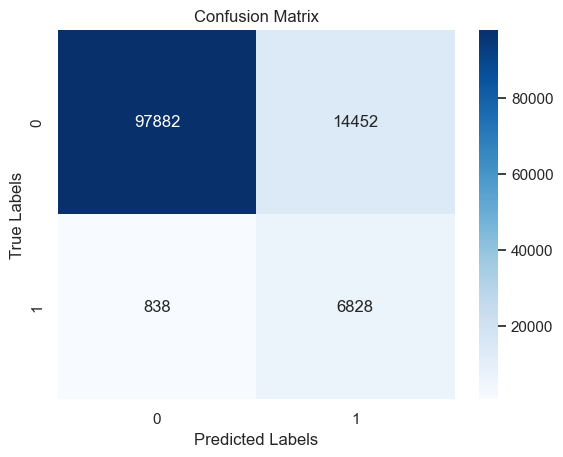

In [61]:
import seaborn as sns

# Predict test values using the LGBM model
y_pred = clf.predict(X_train)

# Calculate the confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Set the axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


#### TEST  моделі із feature selected


Test AUC = 0.896


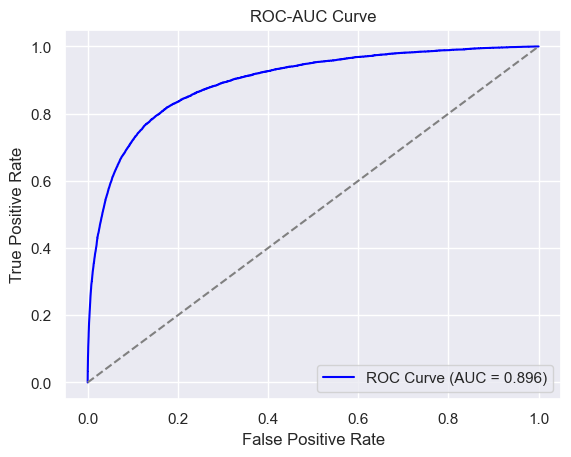

In [77]:

import lightgbm as lgb
import pickle
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Define the file name of the pickle file
#pickle_file = "LGBMClassifier_01072023_15_28.pickle"
pickle_file = "LGBMClassifier_01072023_17_07.pickle" 
## working last pickle_file = "LGBMClassifier_01072023_15_56.pickle"


# Load the model
model_test, features = my_func.load_pickle(pickle_file)

# Prepare the test data (X_test)


y_test = df_test_fe['target']
#X_test = df_test_fe[selected_features_95]
X_test = df_test_fe[selected_features_293]
#X_test.fillna(-1, inplace=True)

# Make predictions on the test data
y_pred = model_test.predict(X_test)

# Calculate the probabilities of the positive class
y_pred_proba = model_test.predict_proba(X_test)[:, 1]

# Calculate the ROC-AUC score
# Calculate the ROC-AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC = {auc:.3f}")

# Calculate and print out the binary classification metrics
# Calculate and print out the binary classification metrics
#my_func.binary_classification_metrics(y_true_tr=y_test, y_pred_tr=y_pred, report=True)


# Plot the ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='blue', label="ROC Curve (AUC = {:.3f})".format(auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.show()


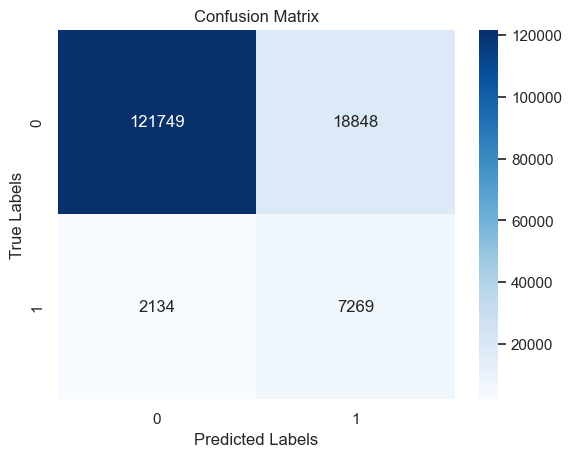

In [78]:
import seaborn as sns

# Predict test values using the LGBM model
y_pred = model_test.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Set the axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [80]:
X_test.shape

(150000, 293)

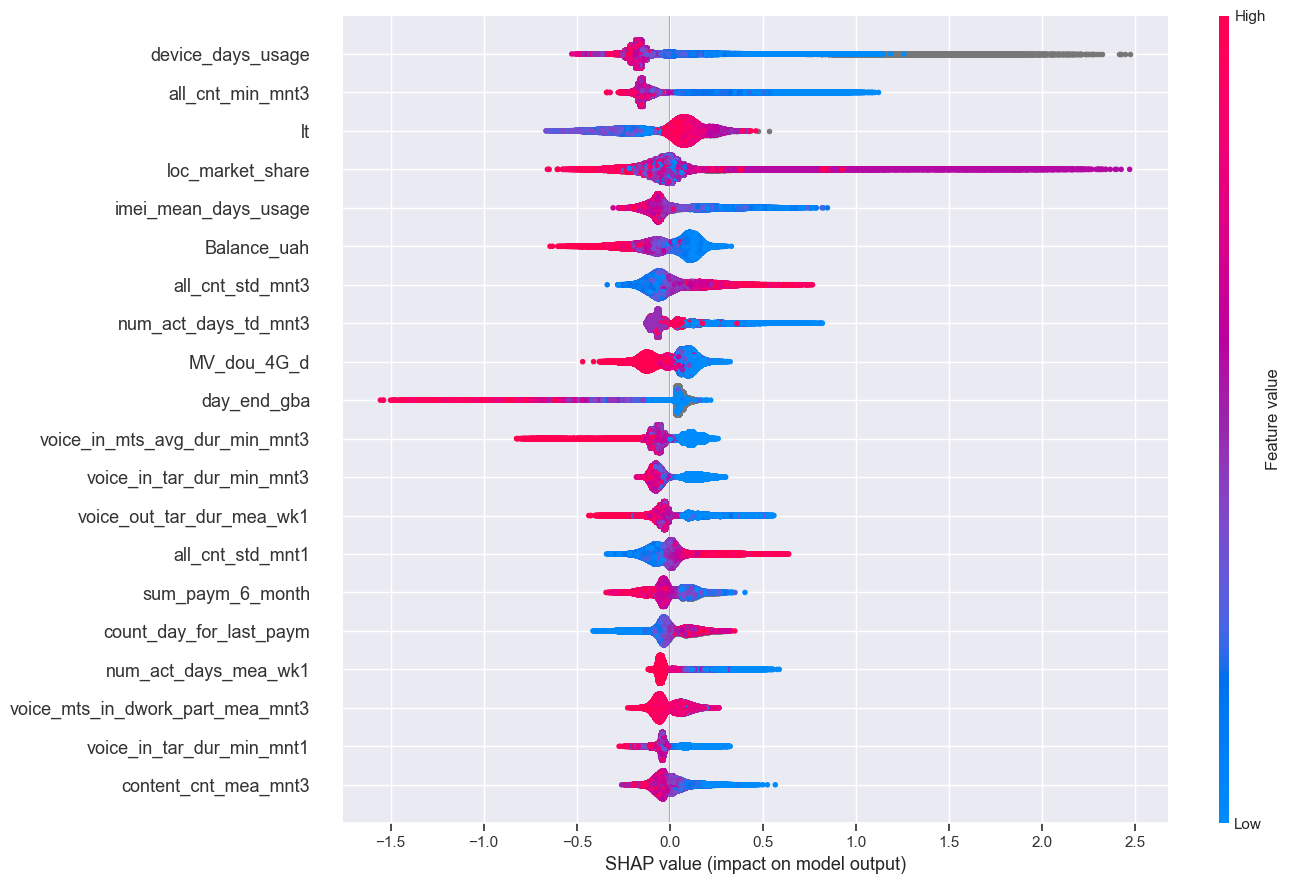

In [79]:
# shap

import shap
fea_lgb = model_test.feature_name_
explainer = shap.TreeExplainer(model_test)
shap_values = explainer.shap_values(X_test[fea_lgb])
pd.DataFrame(shap_values[1])
 
shap.summary_plot(shap_values[1], X_test[fea_lgb], plot_size=(14,9)) 

### Train LGBM on dataset FE_DPI

#### Train model

In [ ]:
## тут буду навчати LGBM на dataset FE+DPI

In [16]:
## missing values
#my_func.count_missing_values(df_train_fe)


In [19]:
# Завантажуємо датасет
df_train_fe = pd.read_pickle('df_train_fe_dpi.pickle')
# Prepare your data (X and y)
X = df_train_fe.drop(['target', 'abon_id'], axis=1)
y = df_train_fe['target']



# Fill missing values with -1
X.fillna(-1, inplace=True)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=777)

In [20]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import pickle
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def my_trainer_lgb(model, X_train, y_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=777)
    callback2 = lgb.log_evaluation(period=50)
    list_tr_acc = []
    list_val_acc = []
    n = 0
    for train_index, val_index in kf.split(X_train):
        n += 1
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_names=['Train', 'Val'], early_stopping_rounds=20, eval_metric='binary_error', callbacks=[callback2])
        
        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)
        
        list_tr_acc.append(accuracy_score(y_tr, y_tr_pred))
        list_val_acc.append(accuracy_score(y_val, y_val_pred))

    print('Total Accuracy (train) =', np.mean(np.array(list_tr_acc)))
    print('Total Accuracy (val) =', np.mean(np.array(list_val_acc)))
    return np.mean(np.array(list_val_acc)) - (np.mean(np.array(list_tr_acc)) - np.mean(np.array(list_val_acc)))



space = {
    'learning_rate': hp.choice('learning_rate', np.arange(0.001, 0.1, 0.001)),
    'max_depth': hp.choice("max_depth", np.arange(2, 7, 1)),
    'num_leaves': hp.choice('num_leaves', np.arange(10, 128, 10, dtype=int))
}

def objective(params):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'num_boost_round': 1000,
        'is_unbalance': True
    }
    clf = lgb.LGBMClassifier(
        n_jobs=-1,
        **param,
        **params
    )  
    score = my_trainer_lgb(clf, X_train, y_train)
    print("AUC {:.3f} params {}".format(score, params))
    return -score

best = fmin(fn=objective, 
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            return_argmin=False)

best.update({
    'objective': 'binary',
    'num_boost_round': 1000,
    'metric': 'auc',
    'is_unbalance': True
})

clf = lgb.LGBMClassifier(**best)

def model_fit(model, X_tr, y_tr, X_val, y_val):
    callback2 = lgb.log_evaluation(period=10)
    model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_names=['Train', 'Val'], early_stopping_rounds=10, eval_metric='binary_error', callbacks=[callback2]) 
    iterr = model.best_iteration_
    y_tr_pred = model.predict(X_tr, num_iteration=iterr)
    y_val_pred = model.predict(X_val, num_iteration=iterr)
    print('Accuracy (train) =', accuracy_score(y_tr, y_tr_pred))
    print('Accuracy (val) =', accuracy_score(y_val, y_val_pred))
    return model

clf = model_fit(clf, X_train, y_train, X_val, y_val)


[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
Total Accuracy (train) =                              
0.9407479166666667                                    
Total Accuracy (val) =                                
0.9404666666666668                                    
AUC 0.940 params {'learning_rate': 0.038, 'max_depth': 6, 'num_leaves': 20}
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current

In [21]:
#saving model
my_func.save_model(clf, X.columns.tolist()) 

Save LGBMClassifier_01072023_10_02.pickle


## Test model on df_test_fe_dpi


In [33]:
# завантажуємо датасет
df_test_fe_dpi = pd.read_pickle('df_test_fe_dpi.pickle')

In [ ]:
#df_test_fe_dpi.head()

Test AUC = 0.844


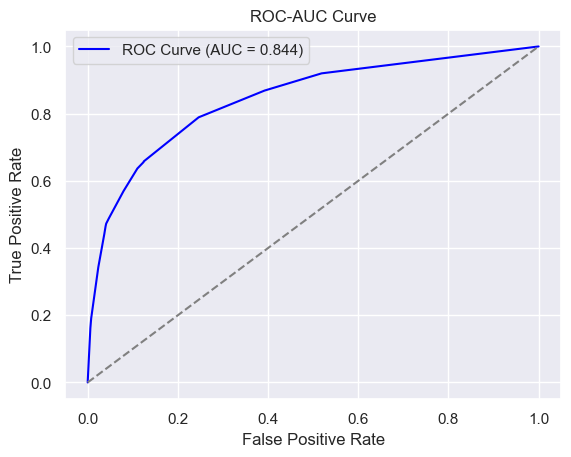

In [34]:

import lightgbm as lgb
import pickle
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

df_test_fe_dpi = pd.read_pickle('df_test_fe_dpi.pickle')

# Define the file name of the pickle file

#pickle_file = "LGBMClassifier_30062023_10_36.pickle"
pickle_file = "LGBMClassifier_01072023_10_02.pickle"

# Load the model
model_test_fe_dpi, features = my_func.load_pickle(pickle_file)

# Prepare the test data (X_test)


y_test = df_test_fe_dpi['target']
X_test = df_test_fe_dpi.drop(['target', 'abon_id'], axis=1)
X_test.fillna(-1, inplace=True)

# Make predictions on the test data
y_pred = model_test_fe_dpi.predict(X_test)

# Calculate the probabilities of the positive class
y_pred_proba = model_test_fe_dpi.predict_proba(X_test)[:, 1]

# Calculate the ROC-AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC = {auc:.3f}")

# Plot the ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='blue', label="ROC Curve (AUC = {:.3f})".format(auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.show()


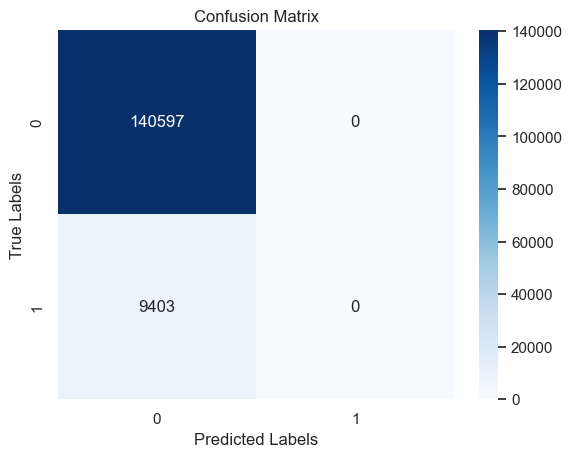

In [35]:
import seaborn as sns

# Predict test values using the LGBM model
y_pred = model_test_fe_dpi.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Set the axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

## Feature Importance

In [ ]:


X = df_train_fe.drop(['target', 'abon_id'], axis=1)
# Get feature importances
# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame with feature names and importances
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})


# Sort the DataFrame by importance in descending order
df_importances = df_importances.sort_values(by='Importance', ascending=False)

# Print the DataFrame
df_importances




In [ ]:


# Save selected_features to a file
with open('selected_features.pickle', 'wb') as file:
    pickle.dump(selected_features, file)


In [ ]:
#save feature importance in file to compare later
df_importances.to_excel('feature_import_24062023_15_30.xlsx')

## Feature Engineering


## Working with missing values

In [66]:
# перевірка на missing значення
ms_val = my_func.count_missing_values(df_train_fe[selected_features_293])
ms_val

,Column,Missing Values,Missing Values (%)
277,tsoa_chat_cnt,145709,97.139333
221,bs_delte_mb_change_tp,140716,93.810667
235,bs_delte_ppm_change_tp,140716,93.810667
212,bs_delte_omo_change_tp,140716,93.810667
227,bs_day_of_change_tp,140716,93.810667
...,...,...,...
228,MV_ARPU,1117,0.744667
10,loc_is_obl_center,880,0.586667
59,loc_cnt_events,880,0.586667
0,loc_market_share,880,0.586667


In [67]:
X = df_train_fe[selected_features_293]
# Get feature importances
# Get feature importances
importances = model_test.feature_importances_
feature_names = X.columns

# Create a DataFrame with feature names and importances
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})


# Sort the DataFrame by importance in descending order
df_importances = df_importances.sort_values(by='Importance', ascending=False)






In [71]:
# Merge the two dataframes on the 'Feature' and 'Column' columns
df_merged = ms_val.merge(df_importances, left_on='Column', right_on='Feature', how='left')

# Drop the 'Feature' column as it's redundant
df_merged = df_merged.drop('Feature', axis=1)

# Fill the missing importances with 0
df_merged['Importance'] = df_merged['Importance'].fillna(0)
# Sort the dataframe by the 'Importance' column in descending order
df_sorted = df_merged.sort_values(by='Importance', ascending=False)

# Print the sorted dataframe
df_sorted




,Column,Missing Values,Missing Values (%),Importance
96,loc_market_share,880,0.586667,119
97,lt,673,0.448667,64
62,device_days_usage,7235,4.823333,57
92,imei_mean_days_usage,1349,0.899333,37
6,day_end_gba,138497,92.331333,31
...,...,...,...,...
75,MV_ARPU_mn_out_v_Traf,1713,1.142000,1
74,MV_ARPU_innet_out_s_Traf,1713,1.142000,1
11,DNZ_MIN_days_closed_loan_year2,135794,90.529333,1
59,device_type_modem,7235,4.823333,1


In [72]:
df_sorted.to_excel('missing_important_fea.xlsx')

### Ідея ще раз зменшити кількість фічей по останній моделі

In [51]:
# Get feature importances
# завантажуємо модель
pickle_file = "LGBMClassifier_01072023_15_56.pickle"
# Load the model
model_train, features = my_func.load_pickle(pickle_file)

312

In [55]:

importances = model_train.feature_importances_
feature_names = features

# Create a DataFrame with feature names and importances
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
df_importances = df_importances.sort_values(by='Importance', ascending=False)

# Print the DataFrame
df_feature_imp = df_importances[df_importances['Importance']>0]



In [57]:
selected_features_293 = df_feature_imp['Feature']

In [75]:
df_train_fe['day_end_gba']

0          NaN
1          NaN
2          NaN
3          NaN
4         26.5
          ... 
149995     NaN
149996     NaN
149997     NaN
149998     NaN
149999     NaN
Name: day_end_gba, Length: 150000, dtype: float16


### Transform DPI dataset



### function for transforming DPI dataset

In [4]:



# Unique values of 'Application'
unique_abon_ids = df_train_dpi['abon_id'].unique()
unique_values_train = df_train_dpi['Application'].unique()
unique_values_test = df_test_dpi['Application'].unique()
unique_applications = np.unique(np.concatenate((unique_values_train, unique_values_test)))
#unique_applications = np.array([14, 23])

# Create the df_t dataframe with 'abon_id' column
df_t = pd.DataFrame({'abon_id': unique_abon_ids})

# Pre-filter df_train_dpi for each application
filtered_dfs = {}
for app in unique_applications:
    filtered_dfs[app] = df_train_dpi[df_train_dpi['Application'] == app]

# Initialize dictionaries to store column values
column_values = {}
for app in unique_applications:
    col_names = [f"{app}_SUM_of_Duration_sec", f"{app}_SUM_of_Volume_kb", f"{app}_SUM_of_Count_events", f"{app}_MAX_of_day_cnt"]
    column_values[col_names[0]] = []
    column_values[col_names[1]] = []
    column_values[col_names[2]] = []
    column_values[col_names[3]] = []

# Progress update interval in seconds
progress_interval = 3 * 60  # 3 minutes

# Iterate over each row in df_t
total_rows = len(df_t)
start_time = time.time()
last_progress_time = start_time
for row_index, row in df_t.iterrows():
    abon_id = row['abon_id']
    
    # Iterate over each application
    for app_index, app in enumerate(unique_applications):
        col_names = [f"{app}_SUM_of_Duration_sec", f"{app}_SUM_of_Volume_kb", f"{app}_SUM_of_Count_events", f"{app}_MAX_of_day_cnt"]
        filtered_df = filtered_dfs[app]
        
        # Find the values for the current abon_id and application
        values = filtered_df.loc[filtered_df['abon_id'] == abon_id, ['SUM_of_Duration_sec', 'SUM_of_Volume_kb', 'SUM_of_Count_events', 'MAX_of_day_cnt']].values
        
        if len(values) > 0:
            column_values[col_names[0]].append(values[0][0])
            column_values[col_names[1]].append(values[0][1])
            column_values[col_names[2]].append(values[0][2])
            column_values[col_names[3]].append(values[0][3])
        else:
            column_values[col_names[0]].append(None)
            column_values[col_names[1]].append(None)
            column_values[col_names[2]].append(None)
            column_values[col_names[3]].append(None)
    
    # Print progress every 3 minutes
    current_time = time.time()
    elapsed_time = current_time - last_progress_time
    if elapsed_time >= progress_interval:
        progress = (row_index + 1) / total_rows * 100
        print(f"Progress: {progress:.2f}%")
        last_progress_time = current_time

# Add the values as new columns to df_t
for col_name, values in column_values.items():
    df_t[col_name] = values

# Print the resulting df_t dataframe
#print(df_t)


Progress: 0.28%
Progress: 0.55%
Progress: 0.83%
Progress: 1.11%
Progress: 1.38%
Progress: 1.66%
Progress: 1.94%
Progress: 2.21%
Progress: 2.49%
Progress: 2.77%
Progress: 3.04%
Progress: 3.32%
Progress: 3.60%
Progress: 3.87%
Progress: 4.15%
Progress: 4.43%
Progress: 4.70%
Progress: 4.98%
Progress: 5.26%
Progress: 5.54%
Progress: 5.81%
Progress: 6.09%
Progress: 6.37%
Progress: 6.64%
Progress: 6.92%
Progress: 7.20%
Progress: 7.47%
Progress: 7.75%
Progress: 8.02%
Progress: 8.30%
Progress: 8.58%
Progress: 8.86%
Progress: 9.13%
Progress: 9.41%
Progress: 9.69%
Progress: 9.96%
Progress: 10.24%
Progress: 10.52%
Progress: 10.79%
Progress: 11.07%
Progress: 11.35%
Progress: 11.62%
Progress: 11.90%
Progress: 12.18%
Progress: 12.45%
Progress: 12.73%
Progress: 13.01%
Progress: 13.28%
Progress: 13.56%
Progress: 13.84%
Progress: 14.12%
Progress: 14.39%
Progress: 14.67%
Progress: 14.95%
Progress: 15.22%
Progress: 15.50%
Progress: 15.78%
Progress: 16.05%
Progress: 16.33%
Progress: 16.61%
Progress: 16.88%

### loading DPI dataset

In [20]:
# load transformed DPI dataset
#df_test_dpi_t = pd.read_pickle('df_test_dpi_t.pickle')
#df_test_dpi_t=my_func.reduce_mem_usage(df_test_dpi_t)
#df_test_dpi_t.to_pickle('df_test_dpi_t_light.pickle')

In [21]:
# Merge the two datasets based on 'abon_id' column
#df_combined = pd.merge(df_test_fe, df_test_dpi_t, on='abon_id', how='left')

# Check the resulting combined dataframe
#df_combined


In [22]:
# save as pickle
#df_combined.to_pickle('df_test_fe_dpi.pickle')


## LightGBM for fe + dpi dataset

In [21]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import numpy as np

df_train_fe_dpi = pd.read_pickle('df_train_fe_dpi.pickle')
#df_train_fe_dpi = my_func.reduce_mem_usage(df_train_fe_dpi)
df_train_fe_dpi.fillna(-1, inplace=True)

In [ ]:
# select best features and retrain model
df_train_fe_dpi = df_train_fe_dpi[selected_features + ['target']+['abon_id']]
df_train_fe_dpi.shape

In [37]:

# Prepare your data (X and y)
X = df_train_fe_dpi.drop(['target', 'abon_id'], axis=1)
y = df_train_fe_dpi['target']

In [38]:


# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=777)

# Define the LGBMClassifier model
clf = lgb.LGBMClassifier(is_unbalance=True)

# Define the number of folds for cross-validation
n_splits = 5

# Initialize an empty list to store the test AUC scores for each fold
test_scores = []

# Perform K-fold cross-validation
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)
for train_index, test_index in kf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Train the model on the current fold
    clf.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation set of the current fold
    y_val_pred = clf.predict(X_test_fold)
    
    # Calculate and store the AUC score for the current fold
    test_scores.append(roc_auc_score(y_test_fold, y_val_pred))

# Print the test AUC scores for each fold
for i, score in enumerate(test_scores):
    print(f"Fold {i+1} Test AUC = {score:.3f}")

# Calculate and print the average test AUC across all folds
print(f"Average Test AUC = {np.mean(test_scores):.3f}")

Fold 1 Test AUC = 0.827
Fold 2 Test AUC = 0.823
Fold 3 Test AUC = 0.820
Fold 4 Test AUC = 0.826
Fold 5 Test AUC = 0.820
Average Test AUC = 0.823


In [27]:

# Get feature importances
importances = clf.feature_importances_
feature_names = X.columns

# Create a DataFrame with feature names and importances
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
df_importances = df_importances.sort_values(by='Importance', ascending=False)

# Print the DataFrame
print(df_importances)


                        Feature  Importance
632            loc_market_share          96
606                          lt          55
634           device_days_usage          53
604                 Balance_uah          39
705                 day_end_gba          27
...                         ...         ...
1655  703.0_SUM_of_Duration_sec           0
1657  703.0_SUM_of_Count_events           0
1658       703.0_MAX_of_day_cnt           0
1659  705.0_SUM_of_Duration_sec           0
3882      2578.0_MAX_of_day_cnt           0

[3883 rows x 2 columns]


In [42]:
df_importances.to_pickle('feature_import_LGB_fe_DPI.pickle')

In [ ]:
# Get feature importances
importances = clf.feature_importances_
feature_names = X.columns

# Create a DataFrame with feature names and importances
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Filter features with importance greater than 0
selected_features = df_importances[df_importances['Importance'] > 0]['Feature'].tolist()


#selected_features


In [53]:
# save important selected features
import pickle

# Save selected_features to a file
with open('selected_features_Fe_DPI.pickle', 'wb') as file:
    pickle.dump(selected_features, file)


### Transform Num dataset



## Predict on Test sample
